### <b>Dataset Download</b>

* This dataset has total <b>1,400 images</b>. (train: 1,000 / val: 200 / test: 200)

<pre>
<b>Dataset</b>/
    <b>train</b>/
        <b>cats</b>/
          500 images
        <b>dogs</b>/
          500 images
    <b>val</b>/
        <b>cats</b>/
          100 images
        <b>dogs</b>/
          100 images
    <b>test</b>/
        <b>cats</b>/
          100 images
        <b>dogs</b>/
          100 images
</pre>

In [1]:
!git clone https://github.com/ndb796/Poison-Frogs-OneShotKillAttack-PyTorch
%cd Poison-Frogs-OneShotKillAttack-PyTorch

Cloning into 'Poison-Frogs-OneShotKillAttack-PyTorch'...
remote: Enumerating objects: 1424, done.
remote: Counting objects: 100% (1424/1424), done.
remote: Compressing objects: 100% (1421/1421), done.
remote: Total 1424 (delta 2), reused 1412 (delta 0), pack-reused 0
Receiving objects: 100% (1424/1424), 30.06 MiB | 25.54 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/Poison-Frogs-OneShotKillAttack-PyTorch


### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './simple_dog_and_cat_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
val_datasets = datasets.ImageFolder(os.path.join(data_dir, 'val'), transforms_val)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=16, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=16, shuffle=False, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=16, shuffle=True, num_workers=4)

print('Train dataset size:', len(train_datasets))
print('Validation dataset size:', len(val_datasets))
print('Test dataset size:', len(test_datasets))

class_names = train_datasets.classes
print('Class names:', class_names)

Train dataset size: 1000
Validation dataset size: 200
Test dataset size: 200
Class names: ['cat', 'dog']


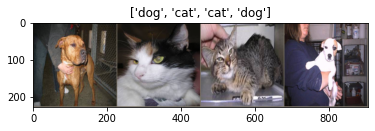

In [5]:
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Define Model</b>

* A fixed AlexNet feature extractor is switched to the <b>eval() mode</b> because AlexNet has a dropout layer.
* We focus on a transfer learning retraining only the FC layer.

In [6]:
class StudentNetwork(nn.Module):
    def __init__(self):
        super(StudentNetwork, self).__init__()

        # load a pre-trained model for the feature extractor
        self.feature_extractor = nn.Sequential(*list(models.alexnet(pretrained=True).children())[:-1]).eval()
        self.fc = nn.Linear(9216, 2) # binary classification (num_of_class == 2)

        # fix the pre-trained network
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, images):
        features = self.feature_extractor(images)
        x = torch.flatten(features, 1)
        outputs = self.fc(x)
        return features, outputs

In [7]:
model = StudentNetwork().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


### <b>Generate Poison Instance</b>

* <b>A base instance</b>: a randomly selected cat image from the test dataset.
* <b>A target instance</b>: a randomly selected dog image from the test dataset.

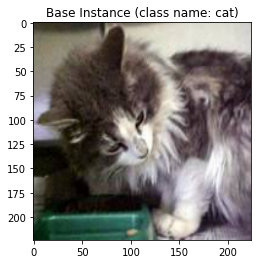

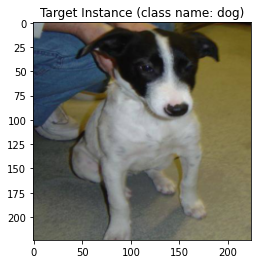

In [10]:
base_instance = None
target_instance = None

for inputs, labels in test_dataloader:
    for i in range(inputs.shape[0]):
        if labels[i].item() == 0: # if it's a cat
            base_instance = inputs[i].unsqueeze(0).to(device)
        elif labels[i].item() == 1: # if it's a dog
            target_instance = inputs[i].unsqueeze(0).to(device)


imshow(base_instance[0].cpu(), f'Base Instance (class name: {class_names[0]})')
imshow(target_instance[0].cpu(), f'Target Instance (class name: {class_names[1]})')

* In this code, we utilize <b>L-infinity</b> bound perturbation because it requires relatively small iterations.

Feature loss: 9.215948104858398, Image loss: 2.484784915055883e-16, Time: 0.0037114620208740234
Feature loss: 0.5778391361236572, Image loss: 0.015879394486546516, Time: 1.0779480934143066
Feature loss: 0.43438881635665894, Image loss: 0.02406478114426136, Time: 2.0749120712280273
Feature loss: 0.3779870569705963, Image loss: 0.029008563607931137, Time: 3.0756561756134033
Feature loss: 0.3514653742313385, Image loss: 0.03249527886509895, Time: 4.040819883346558
Feature loss: 0.33202460408210754, Image loss: 0.03521844744682312, Time: 5.016017436981201
Feature loss: 0.31448623538017273, Image loss: 0.03737678751349449, Time: 5.982722043991089
Feature loss: 0.30259764194488525, Image loss: 0.03915179893374443, Time: 6.96588134765625
Feature loss: 0.29440250992774963, Image loss: 0.04066004604101181, Time: 8.06715202331543
Feature loss: 0.28699731826782227, Image loss: 0.0419093482196331, Time: 9.101551532745361
Feature loss: 0.28245964646339417, Image loss: 0.04299336299300194, Time: 10.

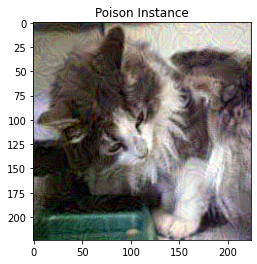

In [11]:
mean_tensor = torch.from_numpy(np.array([0.485, 0.456, 0.406]))
std_tensor = torch.from_numpy(np.array([0.229, 0.224, 0.225]))

unnormalized_base_instance = base_instance.clone()
unnormalized_base_instance[:, 0, :, :] *= std_tensor[0]
unnormalized_base_instance[:, 0, :, :] += mean_tensor[0]
unnormalized_base_instance[:, 1, :, :] *= std_tensor[1]
unnormalized_base_instance[:, 1, :, :] += mean_tensor[1]
unnormalized_base_instance[:, 2, :, :] *= std_tensor[2]
unnormalized_base_instance[:, 2, :, :] += mean_tensor[2]

perturbed_instance = unnormalized_base_instance.clone()
target_features, outputs = model(target_instance)

transforms_normalization = transforms.Compose([
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

epsilon = 16 / 255
alpha = 0.05 / 255

start_time = time.time()
for i in range(5000):
    perturbed_instance.requires_grad = True

    poison_instance = transforms_normalization(perturbed_instance)
    poison_features, _ = model(poison_instance)

    feature_loss = nn.MSELoss()(poison_features, target_features)
    image_loss = nn.MSELoss()(poison_instance, base_instance)
    loss = feature_loss + image_loss / 1e2
    loss.backward()

    signed_gradient = perturbed_instance.grad.sign()

    perturbed_instance = perturbed_instance - alpha * signed_gradient
    eta = torch.clamp(perturbed_instance - unnormalized_base_instance, -epsilon, epsilon)
    perturbed_instance = torch.clamp(unnormalized_base_instance + eta, 0, 1).detach()

    if i == 0 or (i + 1) % 500 == 0:
        print(f'Feature loss: {feature_loss}, Image loss: {image_loss}, Time: {time.time() - start_time}')

poison_instance = transforms_normalization(perturbed_instance)
imshow(poison_instance[0].cpu(), 'Poison Instance')

### <b>Training (Poisoning) Phase</b>

* We <b>don't need</b> to switch a model state to <b>model.train()</b> or <b>model.eval()</b> because we train the only last FC layer.
* And we should use an AlexNet as a fixed feature extractor that is eval() mode.

[Train #0] Loss: 5.8751 Acc: 86.0000% Time: 4.1372s
[Validation #0] Loss: 4.2554 Acc: 89.5000% Time: 5.1177s


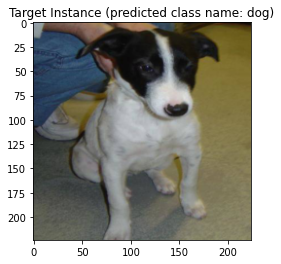

[Predicted Confidence] cat: 7.286752014489049e-44 | dog: 1.0
[Train #1] Loss: 1.9836 Acc: 94.8000% Time: 9.4586s
[Validation #1] Loss: 7.6395 Acc: 88.0000% Time: 10.4689s
[Train #2] Loss: 1.3770 Acc: 96.5000% Time: 14.5933s
[Validation #2] Loss: 4.3358 Acc: 91.0000% Time: 15.5717s
[Train #3] Loss: 1.1924 Acc: 95.9000% Time: 19.7889s
[Validation #3] Loss: 7.3629 Acc: 88.0000% Time: 20.7891s
[Train #4] Loss: 1.5237 Acc: 96.4000% Time: 25.0393s
[Validation #4] Loss: 6.6118 Acc: 88.5000% Time: 26.0266s
[Train #5] Loss: 0.3488 Acc: 98.8000% Time: 30.1411s
[Validation #5] Loss: 6.0564 Acc: 92.5000% Time: 31.1124s


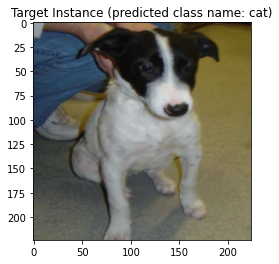

[Predicted Confidence] cat: 1.0 | dog: 3.155081293186382e-36
[Train #6] Loss: 0.1826 Acc: 99.0000% Time: 35.4675s
[Validation #6] Loss: 10.1287 Acc: 89.0000% Time: 36.4372s
[Train #7] Loss: 0.4183 Acc: 98.5000% Time: 40.5536s
[Validation #7] Loss: 6.3652 Acc: 91.0000% Time: 41.5266s
[Train #8] Loss: 0.2535 Acc: 99.0000% Time: 45.6894s
[Validation #8] Loss: 8.1429 Acc: 90.0000% Time: 46.6611s
[Train #9] Loss: 0.3148 Acc: 98.9000% Time: 50.8459s
[Validation #9] Loss: 9.1808 Acc: 90.5000% Time: 51.8234s
[Train #10] Loss: 0.1862 Acc: 99.1000% Time: 56.0009s
[Validation #10] Loss: 8.4655 Acc: 90.5000% Time: 56.9744s


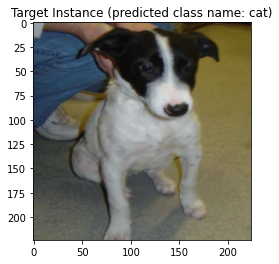

[Predicted Confidence] cat: 1.0 | dog: 0.0
[Train #11] Loss: 0.3912 Acc: 98.7000% Time: 61.2742s
[Validation #11] Loss: 8.6209 Acc: 90.0000% Time: 62.2584s
[Train #12] Loss: 1.7638 Acc: 96.6000% Time: 66.4273s
[Validation #12] Loss: 17.7068 Acc: 88.0000% Time: 67.3883s
[Train #13] Loss: 0.7449 Acc: 98.4000% Time: 71.5555s
[Validation #13] Loss: 20.5267 Acc: 89.5000% Time: 72.5301s
[Train #14] Loss: 0.4555 Acc: 99.0000% Time: 76.7156s
[Validation #14] Loss: 13.0258 Acc: 91.0000% Time: 77.7006s
[Train #15] Loss: 0.2744 Acc: 99.4000% Time: 81.8593s
[Validation #15] Loss: 19.0204 Acc: 89.5000% Time: 82.8631s


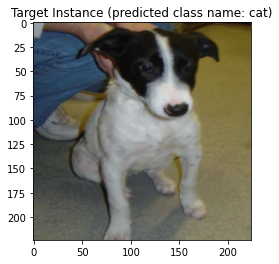

[Predicted Confidence] cat: 1.0 | dog: 0.0
[Train #16] Loss: 0.1910 Acc: 99.4000% Time: 87.2047s
[Validation #16] Loss: 15.2603 Acc: 90.5000% Time: 88.1804s
[Train #17] Loss: 0.4470 Acc: 99.3000% Time: 92.3399s
[Validation #17] Loss: 16.3886 Acc: 90.0000% Time: 93.3302s
[Train #18] Loss: 0.0819 Acc: 99.7000% Time: 97.5642s
[Validation #18] Loss: 15.9273 Acc: 90.0000% Time: 98.5772s
[Train #19] Loss: 0.0000 Acc: 100.0000% Time: 102.8198s
[Validation #19] Loss: 15.3954 Acc: 89.5000% Time: 103.8103s
[Train #20] Loss: 0.0104 Acc: 99.8000% Time: 107.9994s
[Validation #20] Loss: 14.6388 Acc: 90.5000% Time: 109.0026s


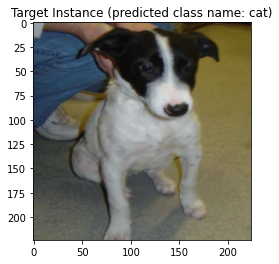

[Predicted Confidence] cat: 1.0 | dog: 0.0
[Train #21] Loss: 0.0000 Acc: 100.0000% Time: 113.3961s
[Validation #21] Loss: 15.0667 Acc: 90.5000% Time: 114.4203s
[Train #22] Loss: 0.0000 Acc: 100.0000% Time: 118.6156s
[Validation #22] Loss: 15.0673 Acc: 90.5000% Time: 119.6175s
[Train #23] Loss: 0.0000 Acc: 100.0000% Time: 123.7625s
[Validation #23] Loss: 15.0673 Acc: 90.5000% Time: 124.7517s
[Train #24] Loss: 0.1258 Acc: 99.8000% Time: 128.9480s
[Validation #24] Loss: 13.2332 Acc: 92.0000% Time: 129.9766s
[Train #25] Loss: 0.0000 Acc: 100.0000% Time: 134.1758s
[Validation #25] Loss: 13.4108 Acc: 92.0000% Time: 135.2347s


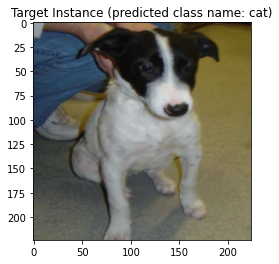

[Predicted Confidence] cat: 1.0 | dog: 0.0
[Train #26] Loss: 0.0000 Acc: 100.0000% Time: 139.6023s
[Validation #26] Loss: 13.4100 Acc: 92.0000% Time: 140.6199s
[Train #27] Loss: 0.0000 Acc: 100.0000% Time: 144.9127s
[Validation #27] Loss: 13.4100 Acc: 92.0000% Time: 145.9067s
[Train #28] Loss: 0.0000 Acc: 100.0000% Time: 150.0540s
[Validation #28] Loss: 13.4093 Acc: 92.0000% Time: 151.0489s
[Train #29] Loss: 0.0000 Acc: 100.0000% Time: 155.2209s
[Validation #29] Loss: 13.4084 Acc: 92.0000% Time: 156.2118s
[Train #30] Loss: 0.0000 Acc: 100.0000% Time: 160.4307s
[Validation #30] Loss: 13.4079 Acc: 92.0000% Time: 161.4256s


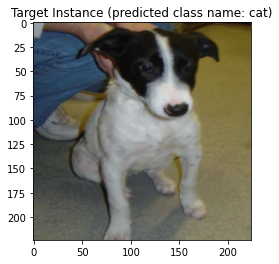

[Predicted Confidence] cat: 1.0 | dog: 0.0
[Train #31] Loss: 0.0000 Acc: 100.0000% Time: 165.7854s
[Validation #31] Loss: 13.4073 Acc: 92.0000% Time: 166.7613s
[Train #32] Loss: 0.0000 Acc: 100.0000% Time: 170.9251s
[Validation #32] Loss: 13.4068 Acc: 92.0000% Time: 171.9405s
[Train #33] Loss: 0.0000 Acc: 100.0000% Time: 176.1393s
[Validation #33] Loss: 13.4064 Acc: 92.0000% Time: 177.1296s
[Train #34] Loss: 0.0000 Acc: 100.0000% Time: 181.3736s
[Validation #34] Loss: 13.4060 Acc: 92.0000% Time: 182.3750s
[Train #35] Loss: 0.0000 Acc: 100.0000% Time: 186.5431s
[Validation #35] Loss: 13.4060 Acc: 92.0000% Time: 187.5351s


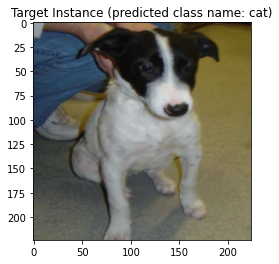

[Predicted Confidence] cat: 1.0 | dog: 0.0
[Train #36] Loss: 0.0000 Acc: 100.0000% Time: 192.1529s
[Validation #36] Loss: 13.4060 Acc: 92.0000% Time: 193.3991s
[Train #37] Loss: 0.0000 Acc: 100.0000% Time: 197.8249s
[Validation #37] Loss: 13.4056 Acc: 92.0000% Time: 199.0568s
[Train #38] Loss: 0.0000 Acc: 100.0000% Time: 203.4777s
[Validation #38] Loss: 13.4056 Acc: 92.0000% Time: 204.7365s
[Train #39] Loss: 0.0000 Acc: 100.0000% Time: 209.1895s
[Validation #39] Loss: 13.4056 Acc: 92.0000% Time: 210.4477s
[Train #40] Loss: 0.0000 Acc: 100.0000% Time: 214.8683s
[Validation #40] Loss: 13.4056 Acc: 92.0000% Time: 216.1162s


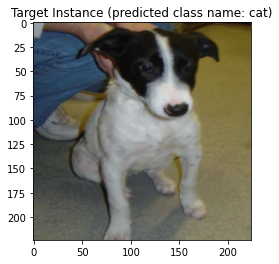

[Predicted Confidence] cat: 1.0 | dog: 0.0
[Train #41] Loss: 0.0000 Acc: 100.0000% Time: 220.4971s
[Validation #41] Loss: 13.4052 Acc: 92.0000% Time: 221.5048s
[Train #42] Loss: 0.0000 Acc: 100.0000% Time: 225.7131s
[Validation #42] Loss: 13.4048 Acc: 92.0000% Time: 226.6968s
[Train #43] Loss: 0.0000 Acc: 100.0000% Time: 230.9811s
[Validation #43] Loss: 13.4048 Acc: 92.0000% Time: 232.0039s
[Train #44] Loss: 0.0000 Acc: 100.0000% Time: 236.1662s
[Validation #44] Loss: 13.4045 Acc: 92.0000% Time: 237.1463s
[Train #45] Loss: 0.0000 Acc: 100.0000% Time: 241.3465s
[Validation #45] Loss: 13.4041 Acc: 92.0000% Time: 242.3543s


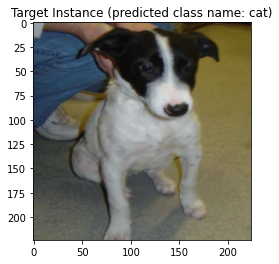

[Predicted Confidence] cat: 1.0 | dog: 0.0
[Train #46] Loss: 0.0000 Acc: 100.0000% Time: 246.7124s
[Validation #46] Loss: 13.4038 Acc: 92.0000% Time: 247.6984s
[Train #47] Loss: 0.0000 Acc: 100.0000% Time: 251.8234s
[Validation #47] Loss: 13.4034 Acc: 92.0000% Time: 252.8217s
[Train #48] Loss: 0.0000 Acc: 100.0000% Time: 256.9513s
[Validation #48] Loss: 13.4034 Acc: 92.0000% Time: 257.9581s
[Train #49] Loss: 0.0000 Acc: 100.0000% Time: 262.1539s
[Validation #49] Loss: 13.4034 Acc: 92.0000% Time: 263.1870s


In [12]:
num_epochs = 50
start_time = time.time()

for epoch in range(num_epochs):
    """ Training Phase """
    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):

        # for the first batch
        if i == 0:
            # change the first data to poison image
            inputs[0] = poison_instance[0]
            labels[0] = torch.tensor(0)

        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()

        features, outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Validation Phase """
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            features, outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_datasets)
        epoch_acc = running_corrects / len(val_datasets) * 100.
        print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    if (epoch == 0) or epoch % 5 == 0:
        """ Poisoning Attack Test Phase """
        with torch.no_grad():
            _, outputs = model(target_instance)
            _, preds = torch.max(outputs, 1)

            imshow(target_instance[0].cpu(), f'Target Instance (predicted class name: {class_names[preds.item()]})')
            percentages = nn.Softmax(dim=1)(outputs)[0]
            print(f'[Predicted Confidence] {class_names[0]}: {percentages[0]} | {class_names[1]}: {percentages[1]}')

### <b>Attack Phase</b>

* Finally, when we input the target instance, we can get the base class (cat) of the base instance.

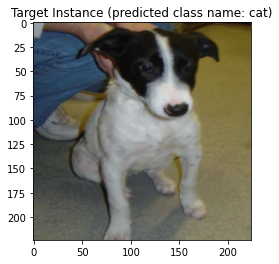

[Predicted Confidence] cat: 1.0 | dog: 0.0


In [13]:
_, outputs = model(target_instance)
_, preds = torch.max(outputs, 1)

imshow(target_instance[0].cpu(), f'Target Instance (predicted class name: {class_names[preds.item()]})')
percentages = nn.Softmax(dim=1)(outputs)[0]
print(f'[Predicted Confidence] {class_names[0]}: {percentages[0]} | {class_names[1]}: {percentages[1]}')